In [ ]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#loading the datasets
dataset1 = pd.read_csv("../data/raw/games.csv", index_col=False) # update 5 months ago 
dataset2 = pd.read_csv("../data/raw/game_data_all.csv") #update 2 years ago 


In [ ]:
#Selecting only the columns we want
dataset1 = dataset1[[
    "AppID",
    "Name",
    "Release date",
    "Price",
    "Windows",
    "Mac",
    "Linux",
    "Genres",
    "Tags"
]]

dataset2 = dataset2[[
    "link",
    "peak_players",
    "positive_reviews",
    "negative_reviews",
    "total_reviews"
]]


In [ ]:
#Preparing for merge

#correcting the 'link' in dataset2 to only be an int. Ex: "/app/2231450/" -> "2231450"
dataset2["app_id"] = dataset2["link"].str.extract(r"/app/(\d+)/")
dataset2["app_id"] = dataset2["app_id"].astype(int)
dataset2 = dataset2.drop(columns=["link"])

#renaming appId to be the same in dataset2
dataset1 = dataset1.rename(columns={"AppID": "app_id"})
dataset1["app_id"] = dataset1["app_id"].astype(int)



In [ ]:
#merge data set
merged_dataset = pd.merge(dataset1, dataset2, on="app_id", how="left")

In [ ]:
# Drop missing values
tags_series = merged_dataset["Tags"].dropna()

# Step 1: Standardize separators by stripping whitespace
split_tags = tags_series.str.replace(",\s*", ",", regex=True).str.split(",")

# Step 2: Explode to get one tag per row
all_tags = split_tags.explode()

# Step 3: Strip any remaining leading/trailing whitespace
all_tags = all_tags.str.strip()

# Step 4: Count tag frequencies
tag_counts = all_tags.value_counts()


In [ ]:
#Histogram for most popular tags
tag_counts.head(10).plot(kind="bar", figsize=(20, 10), title="Top 10 Most Common Tags")
plt.xlabel("Tags")
plt.ylabel("Number of Games")
plt.xticks(rotation=30)
plt.show()


In [ ]:
#Histogram for least popular tags

# Filter tags that appear in at least 50 games
filtered_tags = tag_counts[tag_counts >= 50]

#Get the 10 lowest among those, make the chart flip
lowest_popular_tags = filtered_tags.nsmallest(10)

lowest_popular_tags.tail(10).plot(kind="bar", figsize=(20, 10), title="Bottom 10 Common Tags")
plt.xlabel("Tags")
plt.ylabel("Number of Games")
plt.xticks(rotation=30)
plt.show()

In [ ]:
from itertools import combinations
from collections import Counter

tag_co_occurrence = Counter()

for tag_list in split_tags:
    # Get all unique combinations of 2 tags from each game's list
    for pair in combinations(sorted(set(tag_list)), 2):
        tag_co_occurrence[pair] += 1

# Convert the counter to a DataFrame
tag_matrix = pd.DataFrame.from_dict(tag_co_occurrence, orient='index', columns=["count"])
tag_matrix = tag_matrix.reset_index()
tag_matrix[["Tag1", "Tag2"]] = pd.DataFrame(tag_matrix["index"].tolist(), index=tag_matrix.index)
tag_matrix.drop(columns="index", inplace=True)

In [ ]:
# Pivot the data into a square matrix
tag_heatmap = tag_matrix.pivot(index="Tag1", columns="Tag2", values="count").fillna(0)

# Make it symmetric: add the matrix to its transpose
tag_heatmap = tag_heatmap + tag_heatmap.T

# Optional: reduce to top N most frequent tags (for clarity)
top_tags = tag_heatmap.sum().sort_values(ascending=False).head(13).index
tag_heatmap_filtered = tag_heatmap.loc[top_tags, top_tags]

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(tag_heatmap_filtered, cmap="YlGnBu", linewidths=0.5, linecolor='black', square=True)
plt.title("Most Combined Tag Heatmap")
plt.xticks(rotation=45, ha='right')

plt.show()

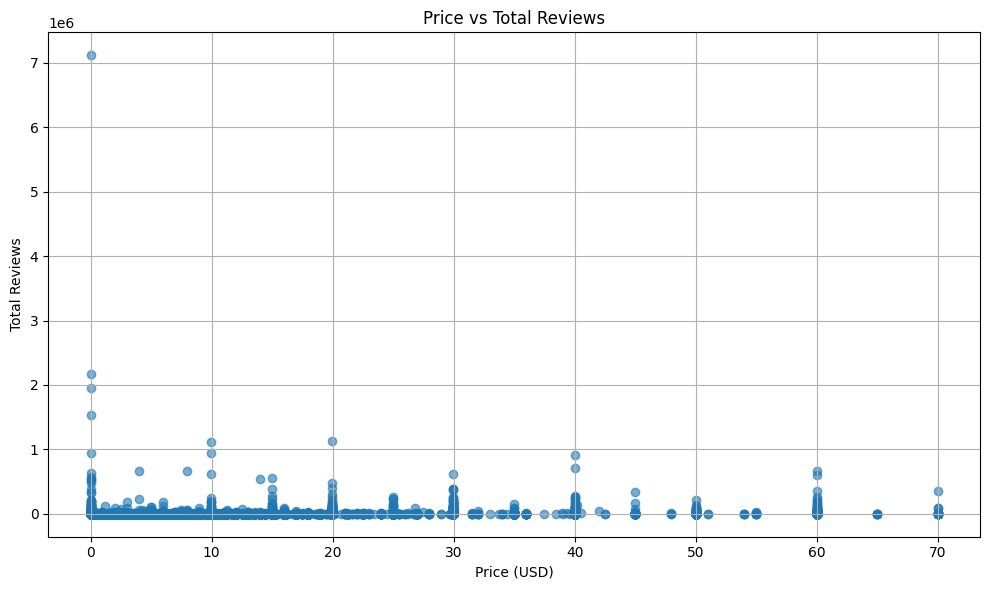

In [69]:
filtered_df = merged_dataset[merged_dataset["Price"] <= 70]

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_df["Price"], filtered_df["total_reviews"], alpha=0.6)

# Axis labels
plt.xlabel("Price (USD)")
plt.ylabel("Total Reviews")
plt.title("Price vs Total Reviews")

# Optional: improve visibility for skewed data
# plt.xscale("log")
# plt.yscale("log")

plt.grid(True)
plt.tight_layout()
plt.show()